In [1]:
import pccmnn as pc
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

csf_dict = pc.load_csf_data()

keys_to_delete = []

ab_dict = pc.load_ab_dict('ab_dict.xlsx', 'TAU')

for key in csf_dict:
    sample = csf_dict[key]
    mask = ~np.isnan(sample[:, 3])
    sample = sample[mask, :]
    csf_dict[key] = sample

    if np.all(np.isnan(sample[:, 0])) or np.all(np.isnan(sample[:, 1]))  or sample.shape[0] < 2 or key not in ab_dict:
        keys_to_delete.append(key)

for key in keys_to_delete:
    del csf_dict[key]

print('number of valid samples:', len(csf_dict))

hid_dim = 32

class ODEModel(nn.Module):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.fc1 = nn.Linear(2, hid_dim)
        self.fc2 = nn.Linear(hid_dim, hid_dim)
        self.fc3 = nn.Linear(hid_dim, hid_dim)
        self.fc4 = nn.Linear(hid_dim, 1)
        self.elu = nn.ELU()

    def forward(self, x):
        x = self.elu(self.fc1(x))
        x = self.elu(self.fc2(x))
        x = self.elu(self.fc3(x))
        x = self.fc4(x)
        return x

class LinearTransform(nn.Module):
    def __init__(self, a, b):
        super(LinearTransform, self).__init__()
        self.a = nn.Parameter(torch.tensor(a, dtype=torch.float64, requires_grad=True))
        self.b = nn.Parameter(torch.tensor(b, dtype=torch.float64, requires_grad=True))

    def forward(self, t):
        s = self.a * t + self.b
        return s

model_abeta = torch.load('model_abeta.pt')
model_tau = torch.load('model_tau.pt')

number of valid samples: 305


In [2]:
import torch
import numpy as np

def fill_nan_with_ode(s: torch.Tensor, 
                      param: torch.Tensor, 
                      model: torch.nn.Module, 
                      input_cols: list = None, 
                      param_dict: dict = None) -> torch.Tensor:
    """
    使用ODE模型填充NaN值，确保不覆盖已有的有效值。
    Args:
        s: 独立变量张量（通常是时间/空间坐标），类型为 torch.float64
        param: 待处理的参数张量，类型为 torch.float64
        model: 用于预测导数的模型，权重类型为 torch.float64
        input_cols: 其他需要作为输入的参数列（用于tau处理）
        param_dict: 其他参数的字典（用于tau处理）
    Returns:
        填充后的参数张量，类型为 torch.float64
    """
    # 找到所有有效值的索引
    valid_indices = torch.where(~torch.isnan(param))[0]
    
    # 如果没有有效值，直接返回
    if len(valid_indices) == 0:
        return param
    
    # 找到最后一个有效值的索引
    last_valid_idx = valid_indices[-1].item()
    # 反向填充
    for i in range(last_valid_idx - 1, -1, -1):
        if torch.isnan(param[i]):
            # 找到正向最接近的有效值
            nearest_valid_idx = valid_indices[valid_indices > i][0] if valid_indices[valid_indices > i].numel() > 0 else last_valid_idx
            
            # 构建输入
            if input_cols:  # tau需要额外输入
                inputs = torch.stack([param_dict[col][nearest_valid_idx] for col in input_cols])
            else:  # abeta处理
                inputs = param[nearest_valid_idx].unsqueeze(0)
            
            # 确保输入是 double 类型
            inputs = inputs.double()
            
            # 计算导数并填充
            dx = model(inputs.unsqueeze(0))  # 添加 batch 维度
            param[i] = param[nearest_valid_idx] + dx * (s[i] - s[nearest_valid_idx])
    
    # 正向填充
    for i in range(last_valid_idx + 1, len(param)):
        if torch.isnan(param[i]):
            # 使用最后一个有效值
            nearest_valid_idx = last_valid_idx
            
            # 构建输入
            if input_cols:  # tau需要额外输入
                inputs = torch.stack([param_dict[col][nearest_valid_idx] for col in input_cols])
            else:  # abeta处理
                inputs = param[nearest_valid_idx].unsqueeze(0)
            
            # 确保输入是 double 类型
            inputs = inputs.double()
            
            # 计算导数并填充
            dx = model(inputs.unsqueeze(0))  # 添加 batch 维度
            param[i] = param[nearest_valid_idx] + dx * (s[i] - s[nearest_valid_idx])
    
    return param

# 主处理流程
for key in csf_dict:
    sample = csf_dict[key].copy()  # 避免修改原始数据
    
    # 转换为张量（统一设备，类型为 torch.float64）
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    s = torch.tensor(sample[:, 0], dtype=torch.float64, device=device)
    abeta = torch.tensor(sample[:, 1], dtype=torch.float64, device=device)
    tau = torch.tensor(sample[:, 2], dtype=torch.float64, device=device)
    
    # 确保模型是 double 类型
    model_abeta = model_abeta.double().to(device)
    model_tau = model_tau.double().to(device)
    
    with torch.no_grad():
        # 处理abeta（单变量ODE）
        abeta = fill_nan_with_ode(s, abeta, model_abeta)
        
        # 处理tau（需要abeta作为输入）
        tau = fill_nan_with_ode(
            s, 
            tau, 
            model_tau,
            input_cols=["abeta", "tau"],  # 定义输入需要的列
            param_dict={"abeta": abeta, "tau": tau}  # 提供参数字典
        )
        # 回写数据
        sample[:, 1] = abeta.cpu().numpy()
        sample[:, 2] = tau.cpu().numpy()
        csf_dict[key] = sample

In [3]:
model = ODEModel()
import torch.nn.init as init
for layer in model.modules():
    if isinstance(layer, nn.Linear):
        init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
        init.zeros_(layer.bias)

model = model.to(torch.float64)
best_model = copy.deepcopy(model)
initial_lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
loss_fn = nn.MSELoss()
loss_curve = []

from tqdm import tqdm

best_loss = 114514
best_loss_curve = []

ab_curve = []
with tqdm(range(200), desc="Training Progress", unit="epoch") as pbar:
    for epoch in pbar:
        optimizer.zero_grad()
        num = len(csf_dict)
        loss = torch.tensor(0, dtype=torch.float64, requires_grad=True)
        ab_ave_loss = torch.tensor(0, dtype=torch.float64, requires_grad=False)

        for key in csf_dict:
            sample = csf_dict[key]
            a = ab_dict[key][0]
            b = ab_dict[key][1]

            # 为当前 key 创建 LinearTransform 实例
            t2s = LinearTransform(a, b)

            # 为当前 key 的 LinearTransform 参数创建优化器
            optimizer_ab = optim.Adam(t2s.parameters(), lr=initial_lr)

            t = torch.tensor(sample[:, 0], dtype=torch.float64)
            s = t2s(t)
            ab_loss = torch.sum(torch.clamp(s, min=-10, max=20) != s)
            ab_ave_loss += ab_loss

            tau = torch.tensor(sample[:, 2], dtype=torch.float64)
            n = torch.tensor(sample[:, 3], dtype=torch.float64)
            mask = ~torch.isnan(n)
            tau = tau[mask]
            s = s[mask]
            n = n[mask]
            n_pred = pc.predict(model, s, n[0], tau)
            sample_loss = loss_fn(n_pred, n)
            loss = loss + sample_loss

            ab_ave_loss += ab_loss
            ab_loss = ab_loss + 1e3 * sample_loss
            ab_loss.backward(retain_graph=True)
            optimizer_ab.step()
            optimizer_ab.zero_grad()

            ab_dict[key][0] = t2s.a.item()
            ab_dict[key][1] = t2s.b.item()

        loss = loss / num
        ab_ave_loss = ab_ave_loss / num
        ab_curve.append(ab_ave_loss)

        if loss.item() < best_loss:
            best_model = copy.deepcopy(model)
            best_loss = loss.item()

        best_loss_curve.append(best_loss)
        loss_curve.append(loss.item())

        # 动态更新进度条右侧的 loss 信息
        pbar.set_postfix(loss=loss.item(), best_loss=best_loss)

        loss.backward(retain_graph=True)
        optimizer.step()

torch.save(best_model, 'model_n.pt')
pc.save_ab_dict_to_xlsx(ab_dict, 'ab_dict.xlsx', "N")

Training Progress: 100%|██████████| 200/200 [03:55<00:00,  1.18s/epoch, best_loss=0.00184, loss=0.00184]

ab_dict 已保存到 ab_dict.xlsx 的 N sheet 中（已清空旧数据）


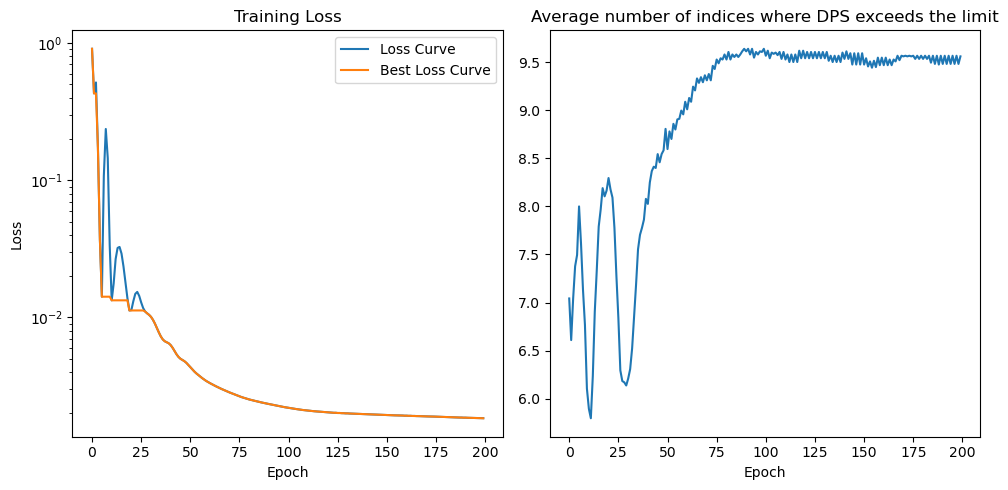

In [4]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 创建2行3列的子图
axes = axes.flatten()  # 将axes转换为1D数组，方便索引
ax = axes[0]
ax.plot(loss_curve, label='Loss Curve')
ax.plot(best_loss_curve, label='Best Loss Curve')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.legend()
ax = axes[1]
ax.plot(ab_curve, label='ab Loss')
ax.set_xlabel('Epoch')
ax.set_title('Average number of indices where DPS exceeds the limit')
plt.tight_layout()  # 调整子图布局，避免重叠
plt.show()  # 显示图像

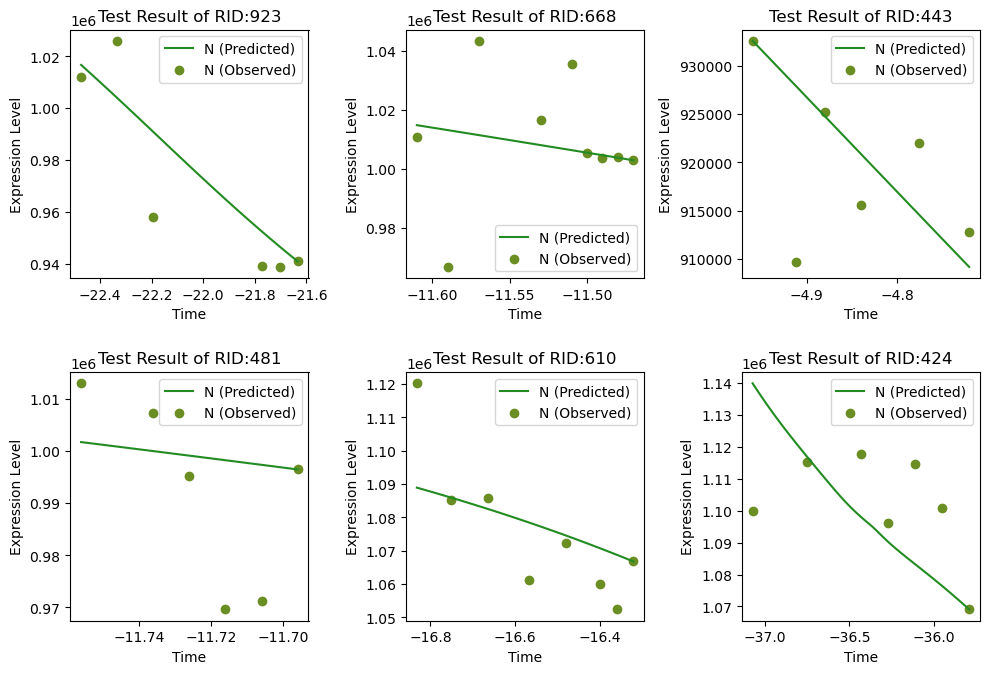

In [14]:
import torch
import torch.nn as nn
import numpy as np
import pccmnn as pc
model_abeta = torch.load('model_abeta.pt')
model_tau = torch.load('model_tau.pt')
model = torch.load('model_n.pt')
ab_dict = pc.load_ab_dict('ab_dict.xlsx', 'N') # 由于预测n需要用到相同时间列的abeta和tau的预测值，因此必须同时使用相同的a,b进行线性变换

keys = pc.sampling(csf_dict, 6, 6)  # 获取6个不同的key
fig, axes = plt.subplots(2, 3, figsize=(10, 7))  # 创建2行3列的子图
axes = axes.flatten()  # 将axes转换为1D数组，方便索引

for i, key in enumerate(keys):
    sample = csf_dict[key]
    a, b = ab_dict[key][0], ab_dict[key][1]
    t = sample[:, 0]
    s = a * t + b
    s_pred = np.linspace(s[0], s[-1], 100)
    
    abeta0 = torch.tensor(sample[0, 1])
    abeta_pred = pc.predict(model_abeta, s_pred, abeta0).cpu().detach().numpy()
    
    tau0 = torch.tensor(sample[0, 2])
    tau_pred = pc.predict(model_tau, s_pred, tau0, abeta_pred).cpu().detach().numpy()
    
    n = sample[:, 3]
    n0 = torch.tensor(sample[0, 3])
    n_pred = pc.predict(model, s_pred, n0, tau_pred).cpu().detach().numpy()
    
    n_pred = pc.re_nor(n_pred, 2)
    n = pc.re_nor(n, 2)
    
    # 选择当前的子图
    ax = axes[i]
    ax.plot(s_pred, n_pred, label='N (Predicted)', color="#228B22")
    ax.scatter(s, n, color="#6B8E23", marker='o', label='N (Observed)')
    ax.set_xlabel('Time')
    ax.set_ylabel('Expression Level')
    ax.set_title(f'Test Result of RID:{key}')
    ax.legend()

plt.tight_layout()  # 调整子图布局，避免重叠
plt.show()  # 显示图像

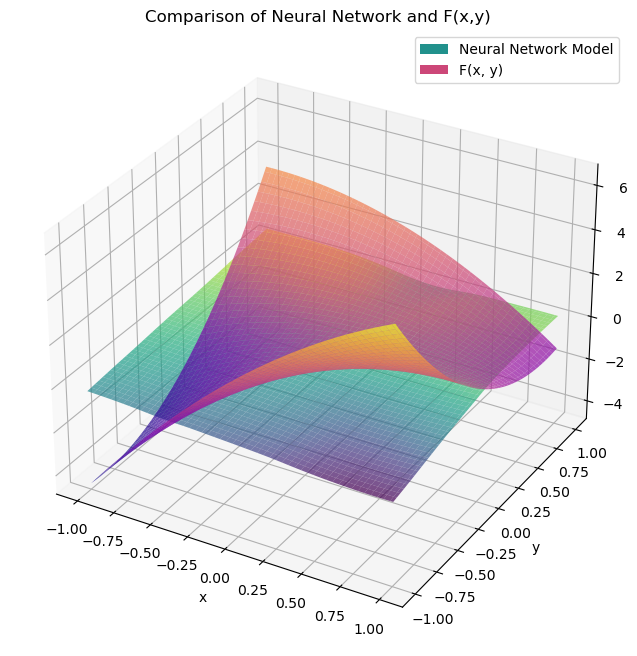

In [6]:
from mpl_toolkits.mplot3d import Axes3D

def F(x,y):
    return 1.627 * x - 1.253 * x ** 2 + 0.018 * y + 2.342 * y ** 2 - 4.015 * x * y

grid_size = 100
x_vals = torch.tensor(np.linspace(-1, 1, grid_size))
y_vals = torch.tensor(np.linspace(-1, 1, grid_size))

X, Y = np.meshgrid(x_vals.numpy(), y_vals.numpy())
input = torch.tensor(np.stack((X.flatten(), Y.flatten()), axis=0).T, dtype=torch.float64)
dx = model(input).detach().numpy().reshape(grid_size, grid_size)
f = F(X, Y)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use plot_surface with explicit colors and labels
surface_dx = ax.plot_surface(X, Y, dx, cmap='viridis', alpha=0.7, label='Neural Network Model')
surface_f = ax.plot_surface(X, Y, f, cmap='plasma', alpha=0.7, label='F(x, y)')

# Manually create proxy artists for the legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=surface_dx.cmap(0.5), label='Neural Network Model'),
                   Patch(facecolor=surface_f.cmap(0.5), label='F(x, y)')]
ax.legend(handles=legend_elements)  # Correct way to add a legend

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
plt.title("Comparison of Neural Network and F(x,y)")
plt.show()